In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os 
os.chdir('/content/drive/Shareddrives/AC297r Project - RFCx /code')

Mounted at /content/drive


In [ ]:
! nvidia-smi 

Sun Nov  6 18:07:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import json
import numpy as np

import tensorflow as tf
from tensorflow.keras import backend as K
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback

from datagen import get_files_and_labels, scalespec, preprocess, DataGenerator
from learningrate import warmup_cosine_decay, WarmUpCosineDecayScheduler


In [ ]:
model_out = './model' # path to output model
data_dir = '/content/drive/Shareddrives/AC297r Project - RFCx /image_data/puerto-rico/train/audio' # path to directory with spectrogram data
# expected format:
#     data_dir/
#         p/
#             <class_1>/
#                 <audio_filename>.npy
#                 ...
#             <class_2>/
#                 <audio_filename>.npy
#                 ...
#         n/
#             <cl ass_1>/
#                 <audio_filename>.npy
#                 ...
#             <class_2>/
#                 <audio_filename>.npy
#                 ...


In [ ]:
# specify list of target classes
class_list = os.listdir(data_dir+'/p/')
num_classes = len(class_list)
num_classes


45

Get training file paths

In [ ]:
%%time
train_split = 0.8

# generate positive train file paths
files_train_p, files_val_p, labels = get_files_and_labels(data_dir+'/p/',
                                                          train_split=train_split,
                                                          random_state=42,
                                                          classes=class_list)

# generate negative train file paths
files_train_n, files_val_n, labels_n = get_files_and_labels(data_dir+'/n/',
                                                            train_split=train_split,
                                                            random_state=42,
                                                            classes=class_list) 

labels_rev = dict((v,k) for (k,v) in labels.items())
files_train_n = [i for i in files_train_n if i.split('/')[-2] in list(labels.keys())]
files_train = files_train_p + files_train_n
files_val = files_val_p + files_val_n


CPU times: user 537 ms, sys: 109 ms, total: 645 ms
Wall time: 2min 16s


Setup data generator

In [ ]:
resize_dim = [224, 224] # desired shape of generated images
augment = 0 # whether to apply data augmentation
batch_size = 32
# batch_size = 8

# train data generator
train_generator = DataGenerator(files_train,
                                labels,
                                resize_dim=resize_dim,
                                batch_size=batch_size,
                                augment=augment)

# validation data generator
val_generator = DataGenerator(files_val,
                              labels,
                              resize_dim=resize_dim,
                              batch_size=batch_size,
                              augment=0)


In [ ]:
%%time
example = train_generator.__getitem__(0)
example = train_generator[0]

CPU times: user 822 ms, sys: 476 ms, total: 1.3 s
Wall time: 18.2 s


In [ ]:
example[0].shape

(32, 224, 224, 3)

Define model

In [ ]:
conv = MobileNetV2(weights='imagenet', 
                   include_top=False, 
                   input_shape=[224, 224, 3])

for layer in conv.layers:
    layer.trainable = True

model = models.Sequential()
model.add(conv)
model.add(layers.AveragePooling2D((7, 7)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam()

# note: this loss can be used to avoid assumptions about unlabeled classes
# def masked_loss(y_true, y_pred):
#     return K.mean(K.mean(K.binary_crossentropy(tf.where(tf.math.is_nan(y_true), tf.zeros_like(y_true), y_true),
#                                                tf.multiply(y_pred, tf.cast(tf.logical_not(tf.math.is_nan(y_true)), tf.float32))), axis=-1))

model.compile(loss='binary_crossentropy', 
              optimizer=optimizer)

model.summary()


9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 average_pooling2d (AverageP  (None, 1, 1, 1280)       0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 45)                57645     
                                                           

In [ ]:
# # save model architecture
# model_json = model.to_json()
# with open(model_out+'.json', "w") as json_file:
#     json_file.write(model_json)
# with open(model_out+'_classes.json', 'w') as f:
#     json.dump(labels_rev, f)
# print('Saved model architecture')


These parameters specify the shape of a learning rate curve that has warmup and cosine decay. See learningrate.py for more details.

In [ ]:
epochs = 20
warmup_lr = 1e-5
warmup_epochs = int(epochs*0.1)
patience = epochs
steps_per_epoch = len(train_generator)
base_lr = 0.0015
hold_base_rate_steps = int(epochs*0.125*steps_per_epoch)

total_steps = int(epochs * steps_per_epoch)
warmup_steps = int(warmup_epochs * steps_per_epoch)


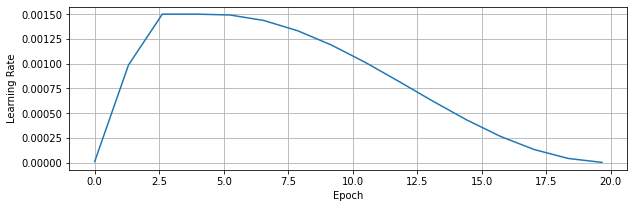

In [ ]:
# plot learning rate
rng = [i for i in range(0, int(epochs * steps_per_epoch), 1000)]
lr = [warmup_cosine_decay(x, 
                          base_lr, 
                          int(epochs*steps_per_epoch), 
                          warmup_lr, 
                          int(warmup_epochs * steps_per_epoch),
                          hold_base_rate_steps) for x in rng]

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 3))
plt.plot([i/steps_per_epoch for i in rng], lr)
plt.grid()
plt.ylabel('Learning Rate')
plt.xlabel('Epoch');
plt.show();
del lr, rng


Setup callbacks

In [ ]:
# save the best model weights based on validation loss
val_chkpt = ModelCheckpoint(filepath=model_out+'_best_val.h5',
                            save_weights_only=True,
                            monitor='val_loss',
                            mode='min',
                            save_best_only=True,
                            verbose=1)

# also save the model weights every 20 epochs
reg_chkpt = ModelCheckpoint(filepath=model_out+'{epoch:04d}.h5',
                            save_weights_only=True,
                            save_freq=int(steps_per_epoch*20))

# apply a learning rate schedule
cosine_warm_up_lr = WarmUpCosineDecayScheduler(learning_rate_base= base_lr,
                                               total_steps= total_steps,
                                               warmup_learning_rate= warmup_lr,
                                               warmup_steps= warmup_steps,
                                               hold_base_rate_steps=hold_base_rate_steps)

callbacks_list = [val_chkpt, reg_chkpt, cosine_warm_up_lr]


Train

In [ ]:
epochs = 1

model_history = model.fit(train_generator,
                          steps_per_epoch = len(train_generator),
                          validation_data = val_generator,
                          epochs = epochs,
                          verbose = 1,
                          callbacks = callbacks_list)
np.save(model_out + '_history.npy', model_history.history)


351/763 [============>.................] - ETA: 1:32:10 - loss: 0.0783